Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE" and remove every line containing the expression: "raise ..." (if you leave such a line your code will not run).

Do not remove any cell from the notebook you downloaded. You can add any number of cells (and remove them if not more necessary). 

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!!!

Fill in your name and id number (numero matricola) below:

In [1]:
NAME = "Emad Shamsaki"
ID_number = int("2005551")

import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

---

# Classification on Wine Dataset

### Dataset description

We will be working with a dataset on wines from the UCI machine learning repository
(http://archive.ics.uci.edu/ml/datasets/Wine ). It contains data for 178 instances. 
The dataset is the results of a chemical analysis of wines grown in the same region
in Italy but derived from three different cultivars. The analysis determined the
quantities of 13 constituents found in each of the three types of wines. 

### The features in the dataset are:

- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
-Proline




We first import all the packages that are needed

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt


import numpy as np
import scipy as sp
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
import copy

In [3]:
np.random.seed(ID_number)

# Perceptron
We will implement the perceptron and use it to learn a halfspace with 0-1 loss.

Load the dataset from scikit learn and then split in training set and test set (50%-50%) after applying a random permutation to the dataset.

In [4]:
# Load the dataset from scikit learn
wine = datasets.load_wine()
# Get input and output data from the dataset
X = wine.data
Y = wine.target
# Create new labels
Y = np.where(Y == 0, -1, Y)
Y = np.where(Y == 2, -1, Y)
# Let's get the number of features
d = X.shape[1]

In [5]:
##### Helper functions, do not modify them. You will need them for the first TODO
def check_constraints(labels, all_possibile_labels, min_num_istances):
    # Count the number of occurrences using numpy
    unique, counts = np.unique(labels, return_counts=True)
    if len(all_possibile_labels) != len(unique):
        return True
    if (counts >= min_num_istances).all():
        return False
    else:
        return True
    
def need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances): 
    return (check_constraints(y_train, all_possibile_labels, min_num_istances) or 
            check_constraints(y_test, all_possibile_labels, min_num_istances))

In [6]:
# TODO 1
# Write a function (create_train_val_test_datasets) which takes as input a dataset and returns 2 datasets: 
# S_t and S_test (different runs are supposed) to return different datasets.
# Write a function (create_train_val_test_datasets_with_constraints) which splits our data in S_t and S_test with 
# the additional constraint that in each dataset we MUST have more than min_num_istances per class.
# Each dataset is represented as a matrix m \times d (numpy ndarray), where m is the number of data and d is the 
# number of features.
# To solve this TODO use the functions we provide you: check_constraints and need_new_shuffle

def create_train_val_test_datasets(features : np.ndarray, labels: np.ndarray, m_t : int, m_test : int):
    '''
    Create training (S_t) and test (S_test) sets starting from a dataset. 
    This function shuffles the complete dataset before creating the subsets. 
    If you call this function twice it is expected to get different S_t, S_test. 
    
    :param features: NumPy ndarray containing all the input data data we can use
    :param labels: NumPy ndarray containing all the labels we have
    :param m_t: Number of samples for the training dataset
    :param m_test: Number of samples for the test dataset
    
    :returns: (x_train, y_train, x_test, y_test)
    :rtype: tuple
        WHERE
        x_train : np.ndarray features in the training dataset
        y_train : np.ndarray labels in the training dataset
        x_test : np.ndarray features in the test dataset
        y_test : np.ndarray labels in the test dataset
    '''
    # SUGGESTION: Use the function np.random.permutation (see the documentation) to create a permutation of the 
    #             dataset indexes. Then use these shuffled indexes to create S_t, S_val, S_test
    # YOUR CODE HERE
    lenY = m_t + m_test
    permutedY=np.random.permutation(lenY)
    x_train=features[permutedY[0:m_t]]
    y_train=labels[permutedY[0:m_t]]
    x_test=features[permutedY[m_t:lenY]]
    y_test=labels[permutedY[m_t:lenY]]
    
    return x_train, y_train, x_test, y_test


def create_train_val_test_datasets_with_constraints(features : np.ndarray, labels: np.ndarray, m_t : int, 
                                                    m_test : int, min_num_istances : int):
    '''
    Same as function above but now we are imposing the constraints: the splitted datasets are assumed to contain 
    at least min_num_istances per class.
    
    ...
    :param min_num_istances: Minimum number of istances per class in each of the splitted datasets
    ...
    
    '''
    all_possibile_labels = np.unique(labels)
    # YOUR CODE HERE
    x_train, y_train, x_test, y_test = create_train_val_test_datasets(features, labels, m_t, m_test)
    
    need_new_shuffle(y_train, y_test, all_possibile_labels, min_num_istances)
    
    return x_train, y_train, x_test, y_test

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

In [7]:
assert x_train.shape == (m_t,       x_train.shape[1]) # here we are comparing two tuples (it is an element wise comparison)
assert x_test.shape  == (len(Y)-m_t, x_test.shape[1])

In [8]:
# Let's add a 1 in front of each sample so that we can use a vector to describe all the coefficients of the model.
# Do not run this cell multiple times otherwise you will continue adding ones... 
# (we add the assert to avoid such issue)

assert x_train.shape[1] == d
assert x_test.shape[1] == d 

x_train = np.hstack((np.ones((x_train.shape[0],1)), x_train))
x_test  = np.hstack((np.ones((x_test.shape[0],1)),  x_test))

**TO DO 2** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where 1 iteration corresponds to 1 update of the perceptron weights. If the perceptron returns because the maximum number of iterations has been reached, you should return an appropriate model (the best seen along the iterations). 

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model
- $w\_iters$: a list of the coefficients found by the algorithm, in those iterations in which the error decreases. This is an 'auxiliary output' (it is not needed for the actual algorithm) that will allows us to have a better insight on the algorithm's behaviour
- $error\_iters$: a list of the *fractions* of missclassified samples for every model found through the same iterations as for the list above. Again an auxiliary output.


**Auxiliary functions**

In order to correclty complete the perceptron function it is warmly recommended to define some auxiliary functions ("*find_missclassified*" and "*choose_missclassified*"). 


"__find_missclassified__"
This function looks for missclassified data points in the dataset $X$.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $curr\_w$: the current value of the parameter vector *w*

The output value is:
- $missclassified\_indeces$: a numpy array cointaining all the missclassified indeces  


"__choose_missclassified__"
This function return one single index choosen from a array of indeces. If the array is empty it returns a non valid index: -1. 

The input parameters to pass are:
- $missclassified\_indeces$: numpy arrya containing missclassified indeces

The output value is:
- $index$: Integer (or np.int64) containing the choosen index


In [9]:
# TODO 2

def find_missclassified(X,Y,curr_w):
    # Here you can use np.argwhere to find which model predictions are correct (this is faster than a for loop)
    # but be carefull on the dimensions of your predictions vector and Y vector.
    # YOUR CODE HERE
    v = X@curr_w
    v = np.where(v>0, 1, -1)
    v = np.squeeze(v)
    
    missclassified_indeces=np.argwhere(v!=Y)
    
    return missclassified_indeces.reshape(-1,)

def choose_missclassified(missclassified_indeces):
    
    if len(missclassified_indeces)==0:
        index=-1
    else:
        index = np.random.choice(missclassified_indeces)
    
    return index

def perceptron(X,Y,max_num_iterations):
    #INITIALIZATION
    curr_w = np.zeros(X.shape[1])
    best_w = curr_w
    num_samples = X.shape[0]
    best_error = num_samples+1  # max + 1 number of possible errors 
    w_iters = []
    error_iters = []
    
    missclassified_indeces = find_missclassified(X,Y, curr_w)
    num_missclassified = len(missclassified_indeces)
    index_missclassified = choose_missclassified(missclassified_indeces)
    
    num_iter = 1  
    
    
    while num_iter < max_num_iterations and index_missclassified != -1:
        
        curr_w = curr_w + Y[index_missclassified]*X[index_missclassified]
        missclassified_indeces = find_missclassified(X,Y, curr_w)
        index_missclassified = choose_missclassified(missclassified_indeces)
        num_missclassified = len(missclassified_indeces)
        
        if best_error > num_missclassified:
            best_error = num_missclassified
            best_w = copy.copy(curr_w)
            w_iters.append(copy.copy(curr_w))
            error_iters.append(best_error)
            
        num_iter += 1
        

        # Update missclassified data points and choose a new missclassified data point
        # YOUR CODE HERE
        
        
        # Update (if necessary) the best error achieved together with the best parameter up to now. 
        # Use copy.copy(curr_w) to copy your current w on "best_w" (since these are arrays you would be copying 
        # only the pointer if you do not use copy.copy) and to append your current w to the list of all w found so far
        # Append the current error to the list of all errors found so far
        # YOUR CODE HERE
        
    best_error = float(best_error)/float(num_samples)
    return best_w, best_error, w_iters, error_iters

In [10]:
index = choose_missclassified(np.array(list(range(100))))
assert type(index) == np.int64 or type(index) == int or type(index) == np.int32


In [11]:
# Now run the perceptron for 100 iterations
# We want just to see the output of the algorithm, so we can avoid assigning the auxiliary outputs to actual variables
w_found, training_error, _, _ = perceptron(x_train, y_train, 100)
print("Training error with 100 iterations: " + str(training_error))

Training error with 100 iterations: 0.2


In [12]:
# TODO 3 
# Write a function to compute the fraction of missclassified samples given two nd.array vectors of shape number of 
# data times 1 (column vectors)
def classification_loss(y_target : np.ndarray, predictions : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples given two vectors: true labels and predictions. 
    :param y_target: output labels
    :param predictions: predictions
    
    :return: Fraction of missclassified samples
    '''

    missclassified_indeces = np.argwhere(y_target != predictions)
    return missclassified_indeces.shape[0] / y_target.shape[0]

# Write a function to comptue the fraction of missclassified samples for a generic dataset given inputs, targets and 
# a vector w.
def compute_fraction_missclassified(X : np.ndarray, Y : np.ndarray, w : np.ndarray) -> float:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    :param X: input locations
    :param Y: targets
    :param w: parameters of the model to be tested
    
    :return: Fraction of missclassified samples
    '''

    Y = Y.reshape(-1,)
    predictions =   X @ w
    predictions = predictions.reshape(-1,)
    for i in range(len(predictions)):
      if (predictions[i] <= 0):
        predictions[i] = -1
      elif (predictions[i] > 0):
        predictions[i] = 1
    
    fraction_missclass = classification_loss(Y , predictions)

    # YOUR CODE HERE
    return fraction_missclass

In [13]:
assert classification_loss(np.array([[1],[3]]), np.array([[1],[3]])) == 0
assert classification_loss(np.array([[1],[2]]), np.array([[1],[3]])) == 0.5
y_labels, y_predictions = np.random.choice(10, 1000000), np.random.choice(10, 1000000)
assert np.isclose(classification_loss(y_labels, y_predictions), 0.9, atol=0.01)
assert training_error == compute_fraction_missclassified(x_train, y_train, w_found)


We now use the best model $w\_found$ to predict the labels for the test dataset and print the fraction of missclassified samples in the test set (that is an estimate of the true loss).

In [14]:
print(f"Training Error for 100 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 100 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 100 iterations is 0.2000
Test Error for 100 iterations is 0.3061


In [15]:
# now run the perceptron for 10000 iterations
# This time we assign also the auxiliary outputs! They will be useful later on!
w_found, training_error, w_list, error_list_train = perceptron(x_train, y_train, 10000)
print(f"Training Error for 10000 iterations is {compute_fraction_missclassified(x_train, y_train, w_found):.4f}")
print(f"Test Error for 10000 iterations is {compute_fraction_missclassified(x_test, y_test, w_found):.4f}")

Training Error for 10000 iterations is 0.1375
Test Error for 10000 iterations is 0.2653


**TO DO 4**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider 100 iterations: what relation do you observe between the training error and the (estimated) true loss? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider 10000 iterations, what has changed? Explain what you observe and why it does or does not conform to your expectations.

1.For 100 iterations, I see the training error is less than the test error. This is what we expect, because we find w for training data and we expect that this error be less from the test data. So this conform to my expectations, because the train error is less than the test error. We also would like the difference between the train and test error be as small as possible. 

2.Regarding 10,000 iterations, we expect that both test error and train error decrease. This will happen. But the train error gets a lot better than the test error. I also see that the difference between the train and test error increase which we don't like this. 

I think, practically for finding the best model, we must change the number of iterations until we get the minimal error for train dataset and minimum difference between train and test error. 


**TO DO 5**: We want to have a better understanding of the hidden behaviour of perceptron algorithm. We indeed defined two auxiliary outputs that should allow us to inspect the training process in more depth. In particular, we want to check if the sequence of models' errors found through the different iterations is characterized by a decreasing trend, with respect to both training and test datasets.

The function `perceptron` already returns the sequence of errors, which is ready to be plotted. However, the errors for the test set aren not immediately available: we nonetheless have all different models, thus we can easily compute them! 

In [192]:
# TODO 5
# Write a function 'error_models' which takes as input a list of models (each of which is a numpy ndarray) and returns
# a list of corresponding errors for a generic dataset
# Suggestion: you can use 'compute_fraction_missclassified' from above to solve this TODO

def error_models(X : np.ndarray, Y : np.ndarray, w_l : list) -> list:
    '''
    This function computes the fraction of missclassified samples of model parametrized by w on the data X w.r.t. 
    targets Y. 
    :param X: input locations
    :param Y: targets
    :param w: list of arrays (models) to be tested
    
    :return: List of fraction of missclassified samples for each model
    '''
    
    errors = []
    for i in range(len(w_l)):
        w_f = w_list[i].reshape(X.shape[1],1)        
        errors.append(compute_fraction_missclassified(X,Y,w_f))
    return errors

In [193]:
assert len(error_models(x_test, y_test, w_list)) == len(error_list_train)
assert len(error_models(x_test, y_test, w_list)) <= 10000


In [194]:
# Let's make 'error_list_train' a fraction of the missclassified samples by dividing for the size of the training set
error_list_train = np.array(error_list_train)/x_train.shape[0]

Text(0.5, 1.0, 'Perceptron test error behaviour')

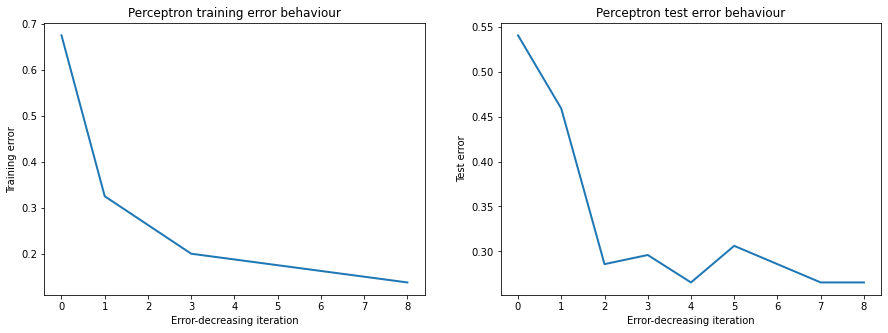

In [195]:
error_list_test = error_models(x_test, y_test, w_list)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot([i for i in range(len(w_list))], error_list_train, linewidth=2)
axes[0].set_xlabel('Error-decreasing iteration')
axes[0].set_ylabel('Training error')
axes[0].set_title('Perceptron training error behaviour')
axes[1].plot([i for i in range(len(w_list))], error_list_test, linewidth=2)
axes[1].set_xlabel('Error-decreasing iteration')
axes[1].set_ylabel('Test error')
axes[1].set_title('Perceptron test error behaviour')

**TO DO 6**: Answer in the next cell (you do not need more than 5-7 lines):

Consider the plot above. How do the two errors compare? Can you identify a particular property of one of them? Why doesn't the other have it?

The training error monotically decrease. In the first steps of the algorithm, the convergence is fast. After some iterations, speed of the convergence will decrease, so the speed of the reaching to the optimal point will decrease. 

For the test error, we have a similar behaviour for the speed of the convergence. However, here, the error doesn't monotically decrease. In some interations, the error is more than its before iteration. You see this special behaviour by a line with the positive slope. This never happens in the training error. Because for training error, we modify the X * W with respect to its last iteration. 

This is also what we expect, because we modify the model on the training datasets and in some iterations, test error may increase with respect to its before iteration. 

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We first do it for 2 labels and then for 3 labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [196]:
import random
# Let's reinitialize the random seed 
random.seed(ID_number)
np.random.seed(ID_number)

# In the following we will keep the dataset with only two classes (which we aggregated before)
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 25)

To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5, max\_iter=?)$

$C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class. Choose the proper number of iterations: max_iter.

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it (have a look at the logreg.score method too).

**TO DO** Define the logistic regression model, then learn the model using the training set and predict on the test set. Then print the fraction of samples missclassified in the training set and in the test set.

In [197]:
# TODO 7
# Logistic regression for 2 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
from sklearn.linear_model import LogisticRegression

max_iter = 1000

logregr = linear_model.LogisticRegression(C=1e5,max_iter = max_iter)
logregr.fit(x_train, y_train)

yhat_train = logregr.predict(x_train)

yhat_test = logregr.predict(x_test)


error_rate_training = classification_loss(y_train, yhat_train)
error_rate_test = classification_loss(y_test, yhat_test)
error_rate_test_sklearn = 1 - logregr.score(x_test, y_test)
print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0
Error rate on test set: 0.10204081632653061
Compare the estimate of generalization with the sklearn implementation 0.10204081632653061


In [198]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

Now we do logistic regression for classification with 3 classes.

In [199]:
random.seed(ID_number)
np.random.seed(ID_number)

X = wine.data
Y = wine.target

m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

_, counts = np.unique(y_train, return_counts=True)
assert (counts >= 20).all()
_, counts = np.unique(y_test, return_counts=True)
assert (counts >= 20).all()

In [200]:
# TODO 8
# Logistic regression for 3 classes
# To compute the error rate (classification loss you can use the function "classification_loss" you built before)
# Choose the proper number of iterations: max_iter.
max_iter = 1000

logregr = linear_model.LogisticRegression(C=1e5,max_iter = max_iter)
logregr.fit(x_train, y_train)

yhat_train = logregr.predict(x_train)

yhat_test = logregr.predict(x_test)

error_rate_training = classification_loss(y_train, yhat_train)
error_rate_test = classification_loss(y_test, yhat_test)
error_rate_test_sklearn = 1 - logregr.score(x_test, y_test)
print("Error rate on training set: "+str(error_rate_training))
print("Error rate on test set: "+str(error_rate_test))
print(f"Compare the estimate of generalization with the sklearn implementation {error_rate_test_sklearn}")

Error rate on training set: 0.0
Error rate on test set: 0.08163265306122448
Compare the estimate of generalization with the sklearn implementation 0.08163265306122447


In [201]:
assert np.isclose(error_rate_test, error_rate_test_sklearn)

**TO DO 9**: Answer in the next cell (you do not need more than 5-7 lines):

1- Consider logistic regression on 2 and 3 classes what relation do you observe between the training error and the (estimated) true loss in both cases? Is this what you expected? Explain what you observe and why it does or does not conform to your expectations.

2- Consider logistic regression on 2 and perceptron with 10000 iterations, which one would you pick? Do you expect perceptron needs more iterations? Explain what you observe and why it does or does not conform to your expectations.

1.In both cases, the train error will reach to the zero. This means that the training datasets are linearly separable. However the test error isn't zero. Here the test error for 3 classes is less than 2 classes issue. I think that's depends on our datasets. 

To be honest, I expected that the error of 3 classes be higher than the error of two classes. but here wasn't like this. I think here the distribution of the data is something like that the number of data which are far from the line that we've found, is more.

I also think that using the 2 classes is easier than 3 classes. Because the complexity is less and it is a less time consuming problem. Actually if we have more than 2 classes, we've always have to use softmax to turn logits to probabilities. 

2.If we consider the speed of the convergence and the train and test error, we should choose the logistic regression.  For logistic regression, both train and test error have decreased. So, it is a better approach to solve the problem. 

I think we can increase the number of iterations in perceptron. Because if we increase the number of iterations, we can see that the error on both train and test will decrease. 



We now are going to plot prediction boundaries of a logistic regression model, in order to plot them we need to reduce the number of features to 2: pick two features and restrict the dataset to include only two features, whose indices are specified in the $feature$ vector below. Then split into training and test.

In [202]:
# TODO 10
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                 'Proline']
labels_list = ['class_0', 'class_1', 'class_2']

index_feature1 = 0  # You can choose the feature you prefer here
index_feature2 = 1  # You can choose the feature you prefer here
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X = X[:,features]

# In the following we will keep the dataset with 3 classes
m_t = 80
x_train, y_train, x_test, y_test = create_train_val_test_datasets_with_constraints(X, Y, m_t, len(Y)-m_t, 20)

max_iter = 1000
logreg = LogisticRegression(C=1e5,max_iter=max_iter)
logreg.fit(x_train,y_train)
# Fit a model on the reduced set of fetures

LogisticRegression(C=100000.0, max_iter=1000)

In [203]:
assert logreg.predict(x_test).shape == (x_test.shape[0], )

The code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

<ipython-input-174-a62ef003d687>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
<ipython-input-174-a62ef003d687>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


Text(0.5, 1.0, 'Test set')

<Figure size 288x216 with 0 Axes>

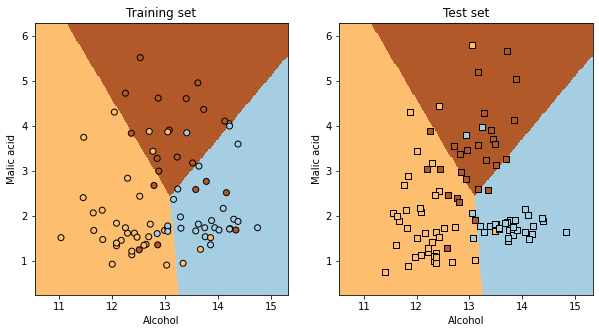

In [174]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
axes[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
axes[0].set_xlabel(feature_name0)
axes[0].set_ylabel(feature_name1)

axes[0].set_xlim(xx.min(), xx.max())
axes[0].set_ylim(yy.min(), yy.max())
axes[0].set_title('Training set')

# Put the result into a color plot
Z = Z.reshape(xx.shape)
axes[1].pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
axes[1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
axes[1].set_xlabel(feature_name0)
axes[1].set_ylabel(feature_name1)

axes[1].set_xlim(xx.min(), xx.max())
axes[1].set_ylim(yy.min(), yy.max())
axes[1].set_title('Test set')

**TO DO 11**: Answer in the next cell (you do not need more than 5-7 lines):

1- What is the shape of the decision boundaries? Why?

2- In this lower dimensional space, are the features linearily separable? What if you consider the entire feature vector (without any dimensionality reduction)?  


1. The number of boundries is equal to the number of classes. If we have two classes, we have two specific boundries. Here we have used logistic regression to classsify our data, so the boundries are linear. Shape of the decision boundries are linear because the logsitic regression is a linear classifier. Also the dimension of the boundries is one dimension less than the number of features. Here that's why we have a line boundary for 2 features.

2. It is obvious that all the features are not lineary separable. However, as the space dimensional gets higher, the features can be seprabale easier by linear function. So, if we consider the entire feature vector, the linear separability gets easier and we could use the linear functions to seprate the features. 
By considering the whole feature vector the chance of having linearly separable data is increasing.